In [9]:
import os, json
from pathlib import Path
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt


In [10]:
BASE_DIR = Path("/Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code")
PROC = BASE_DIR / "data/processed"
RAW  = BASE_DIR / "data/raw"

OUT_ROOT = PROC / "network_sindy_out_DK68_edge_delays"
OUT_ROOT.mkdir(parents=True, exist_ok=True)

# Fixed paths (based on your discovery)
X_path = PROC / "Y_hopf_DK68_varA.npy"      # (T,68)
W_path = PROC / "W_syn_DK68.npy"           # (68,68)
L_path = RAW  / "tract_lengths.txt"        # (68,68)

# Baseline (global delay) metrics for comparison plot
baseline_metrics_path = PROC / "network_sindy_out_DK68" / "metrics_best.json"

print("OUT_ROOT:", OUT_ROOT)
print("X_path:", X_path)
print("W_path:", W_path)
print("L_path:", L_path)


OUT_ROOT: /Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/network_sindy_out_DK68_edge_delays
X_path: /Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/Y_hopf_DK68_varA.npy
W_path: /Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/W_syn_DK68.npy
L_path: /Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/raw/tract_lengths.txt


In [11]:
X = np.load(X_path)
W = np.load(W_path)
L = np.loadtxt(L_path)

print("Loaded shapes:")
print("X:", X.shape)
print("W:", W.shape)
print("L:", L.shape)

# enforce (T,N)
if X.ndim != 2:
    raise ValueError(f"X must be 2D. Got {X.ndim}D.")
if X.shape[0] == 68 and X.shape[1] != 68:
    X = X.T
    print("Transposed X ->", X.shape)

T, N = X.shape
assert W.shape == (N, N), (W.shape, N)
assert L.shape == (N, N), (L.shape, N)

# clean L
L = 0.5*(L + L.T)
np.fill_diagonal(L, 0.0)

print("Final shapes: T,N =", T, N)
print("L stats (mm): min/med/max =", float(L[L>0].min()), float(np.median(L[L>0])), float(L.max()))


Loaded shapes:
X: (68, 2000)
W: (68, 68)
L: (68, 68)
Transposed X -> (2000, 68)
Final shapes: T,N = 2000 68
L stats (mm): min/med/max = 8.0425329 71.218671 252.90276


In [12]:
dt = 0.02  # <-- change ONLY if your Hopf simulation used different dt

v_grid = [3000, 6000, 12000]    # mm/s
tau_cap = 50                    # cap delays in samples

lam_grid = np.logspace(-6, -3, 13)
max_iter = 10

split = int(0.7 * T)

print("dt =", dt, "| split =", split, "/", T)
print("lam_grid:", lam_grid[0], "...", lam_grid[-1], f"(len={len(lam_grid)})")
print("v_grid:", v_grid)


dt = 0.02 | split = 1400 / 2000
lam_grid: 1e-06 ... 0.001 (len=13)
v_grid: [3000, 6000, 12000]


In [13]:
def finite_diff(X, dt):
    dX = np.zeros_like(X)
    dX[1:-1] = (X[2:] - X[:-2]) / (2*dt)
    dX[0] = (X[1] - X[0]) / dt
    dX[-1] = (X[-1] - X[-2]) / dt
    return dX

dX = finite_diff(X, dt)

Xtr, Xva = X[:split], X[split:]
dXtr, dXva = dX[:split], dX[split:]

print("Train:", Xtr.shape, "Val:", Xva.shape)


Train: (1400, 68) Val: (600, 68)


In [14]:
def lengths_to_tau_samples(L_mm, v_mm_s, dt_s, cap=None):
    tau = np.rint(L_mm / (v_mm_s * dt_s)).astype(int)
    tau[tau < 0] = 0
    if cap is not None:
        tau = np.minimum(tau, int(cap))
    np.fill_diagonal(tau, 0)
    return tau

for v in v_grid:
    tau_ij = lengths_to_tau_samples(L, v, dt, cap=tau_cap)
    nz = tau_ij[tau_ij > 0]
    print(f"v={v} mm/s: tau min/med/max =", int(nz.min()), float(np.median(nz)), int(tau_ij.max()))


v=3000 mm/s: tau min/med/max = 1 2.0 4
v=6000 mm/s: tau min/med/max = 1 1.0 2
v=12000 mm/s: tau min/med/max = 1 1.0 1


In [15]:
def build_theta_edge_delay(i, Xseg, tau_ij, W):
    """
    Features for node i:
      [1, x_i, x_i^3, W_i0*x0(t-tau_i0), ..., W_iN*xN(t-tau_iN)]
    Returns Theta_i: (Tseg, 3+N)
    """
    Tseg, N = Xseg.shape
    Theta = np.zeros((Tseg, 3+N), dtype=float)

    xi = Xseg[:, i]
    Theta[:, 0] = 1.0
    Theta[:, 1] = xi
    Theta[:, 2] = xi**3

    for j in range(N):
        tau = int(tau_ij[i, j])
        if tau == 0:
            xj_del = Xseg[:, j]
        else:
            xj_del = np.zeros(Tseg)
            if tau < Tseg:
                xj_del[tau:] = Xseg[:-tau, j]
        Theta[:, 3 + j] = W[i, j] * xj_del

    return Theta


In [16]:
def stlsq(Theta, y, lam, max_iter=10):
    Xi, *_ = np.linalg.lstsq(Theta, y, rcond=None)
    for _ in range(max_iter):
        small = np.abs(Xi) < lam
        Xi[small] = 0.0
        big = ~small
        if big.sum() == 0:
            break
        Xi[big], *_ = np.linalg.lstsq(Theta[:, big], y, rcond=None)
    return Xi

def fit_all_nodes_edge_delay(Xseg, dXseg, W, tau_ij, lam, max_iter=10):
    Tseg, N = Xseg.shape
    Xi_all = np.zeros((N, 3+N))
    for i in range(N):
        Theta_i = build_theta_edge_delay(i, Xseg, tau_ij, W)
        Xi_all[i, :] = stlsq(Theta_i, dXseg[:, i], lam=float(lam), max_iter=max_iter)
    return Xi_all


In [17]:
def one_step_derivative_mse(Xseg, dXseg, W, tau_ij, Xi_all):
    Tseg, N = Xseg.shape
    dXhat = np.zeros_like(dXseg)
    for i in range(N):
        Theta_i = build_theta_edge_delay(i, Xseg, tau_ij, W)
        dXhat[:, i] = Theta_i @ Xi_all[i]
    return float(np.mean((dXseg - dXhat)**2))


In [18]:
edge_results = {}

for v in v_grid:
    tau_ij = lengths_to_tau_samples(L, v, dt, cap=tau_cap)

    best = {"v": v, "lam": None, "val_mse": np.inf, "Xi": None}

    for lam in lam_grid:
        Xi = fit_all_nodes_edge_delay(Xtr, dXtr, W, tau_ij, lam=lam, max_iter=max_iter)
        val_mse = one_step_derivative_mse(Xva, dXva, W, tau_ij, Xi)
        if val_mse < best["val_mse"]:
            best.update({"lam": float(lam), "val_mse": float(val_mse), "Xi": Xi})

    edge_results[v] = best
    print(f"v={v}: best lam={best['lam']:.2e}, val_mse={best['val_mse']:.6f}")


v=3000: best lam=1.00e-04, val_mse=0.006550
v=6000: best lam=5.62e-05, val_mse=0.006374
v=12000: best lam=5.62e-05, val_mse=0.006215


In [19]:
baseline_val = None
if baseline_metrics_path.exists():
    with open(baseline_metrics_path, "r") as f:
        baseline = json.load(f)
    baseline_val = baseline.get("val_mse", None)
    print("Baseline global-delay val_mse:", baseline_val)
else:
    print("[WARN] Baseline metrics not found:", baseline_metrics_path)

best_v = min(edge_results.keys(), key=lambda vv: edge_results[vv]["val_mse"])
best_edge = edge_results[best_v]

print("Best edge-delay:", {"v": best_v, "lam": best_edge["lam"], "val_mse": best_edge["val_mse"]})

out_dir = OUT_ROOT / f"v_{best_v}"
out_dir.mkdir(parents=True, exist_ok=True)

np.save(out_dir / "Xi_best.npy", best_edge["Xi"])

metrics_best = {
    "parcellation": "DK68",
    "system": "hopf",
    "dt": float(dt),
    "velocity_mm_s": int(best_v),
    "tau_cap_samples": int(tau_cap),
    "best_lambda": float(best_edge["lam"]),
    "val_mse": float(best_edge["val_mse"]),
    "baseline_global_val_mse": float(baseline_val) if baseline_val is not None else None,
    "timestamp": datetime.now().strftime("%Y-%m-%d_%H%M%S"),
    "source_X": str(X_path),
    "source_W": str(W_path),
    "source_L": str(L_path),
}

with open(out_dir / "metrics_best.json", "w") as f:
    json.dump(metrics_best, f, indent=2)

print("Saved to:", out_dir)
print(metrics_best)


Baseline global-delay val_mse: 0.04105638579353226
Best edge-delay: {'v': 12000, 'lam': 5.623413251903491e-05, 'val_mse': 0.006215290335061144}
Saved to: /Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/network_sindy_out_DK68_edge_delays/v_12000
{'parcellation': 'DK68', 'system': 'hopf', 'dt': 0.02, 'velocity_mm_s': 12000, 'tau_cap_samples': 50, 'best_lambda': 5.623413251903491e-05, 'val_mse': 0.006215290335061144, 'baseline_global_val_mse': 0.04105638579353226, 'timestamp': '2026-01-01_153526', 'source_X': '/Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/Y_hopf_DK68_varA.npy', 'source_W': '/Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/W_syn_DK68.npy', 'source_L': '/Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/raw/tract_lengths.txt'}


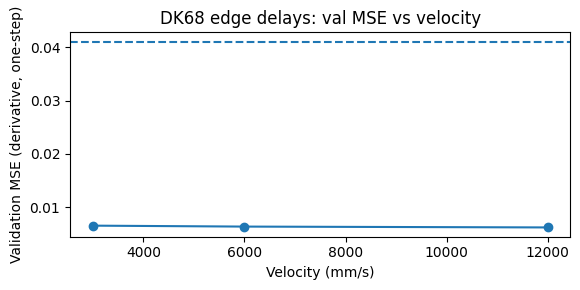

In [20]:
vals = sorted([(v, edge_results[v]["val_mse"]) for v in v_grid], key=lambda t: t[0])

plt.figure(figsize=(6,3))
plt.plot([v for v,_ in vals], [m for _,m in vals], "o-")
if baseline_val is not None:
    plt.axhline(baseline_val, linestyle="--")
plt.xlabel("Velocity (mm/s)")
plt.ylabel("Validation MSE (derivative, one-step)")
plt.title("DK68 edge delays: val MSE vs velocity")
plt.tight_layout()
plt.show()


In [21]:
def nnz_total(Xi):
    return int(np.sum(np.abs(Xi) > 0))

def nnz_per_node_mean(Xi):
    return float(np.mean(np.sum(np.abs(Xi) > 0, axis=1)))

for v in v_grid:
    Xi = edge_results[v]["Xi"]
    print(f"v={v}: nnz_total={nnz_total(Xi)}, nnz/node={nnz_per_node_mean(Xi):.2f}")


v=3000: nnz_total=1514, nnz/node=22.26
v=6000: nnz_total=1834, nnz/node=26.97
v=12000: nnz_total=1836, nnz/node=27.00


In [22]:
impr = (baseline_val - best_edge["val_mse"]) / baseline_val
print("Relative improvement:", impr)


Relative improvement: 0.8486157460055761


In [23]:
tau_ij = lengths_to_tau_samples(L, 12000, dt, cap=tau_cap)
nz = tau_ij[tau_ij>0]
print("tau min/med/max:", nz.min(), np.median(nz), nz.max())


tau min/med/max: 1 1.0 1
